In [22]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import plotly.graph_objects as go
import scipy.io as scio
import random
from matplotlib import pyplot as plt
from scipy.integrate import odeint

In [23]:
def projectile_motion_with_resistance(state, t, g, k, m):
    x, y, v_x, v_y = state
    n = 3
    dx_dt = v_x
    dy_dt = v_y
    dv_x_dt = -(k/m) * v_x**n 
    dv_y_dt = -g - (k/m) * v_y**n
    
    return [dx_dt, dy_dt, dv_x_dt, dv_y_dt]

# 定义参数
g = 9.8  # 重力加速度
k = 0.1  # 空气阻力系数
m = 1.0  # 物体质量

# 定义初始条件
x0 = 0.0  # 初始水平位置
y0 = 10  # 初始垂直位置
v_x0 = 2.0  # 初始水平速度
v_y0 = 0  # 初始垂直速度

# 定义时间点
ts = np.linspace(0, 2, 100)  # 从0到2秒，共取100个时间点

# 定义初始状态向量
initial_state = [x0, y0, v_x0, v_y0]

# 求解ODE方程组
solution_with_resistance = odeint(projectile_motion_with_resistance, initial_state, ts, args=(g, k, m))

# 提取位置和速度信息
x_with_resistance = solution_with_resistance[:, 0]
y_with_resistance = solution_with_resistance[:, 1]
v_x_with_resistance = solution_with_resistance[:, 2]
v_y_with_resistance = solution_with_resistance[:, 3]

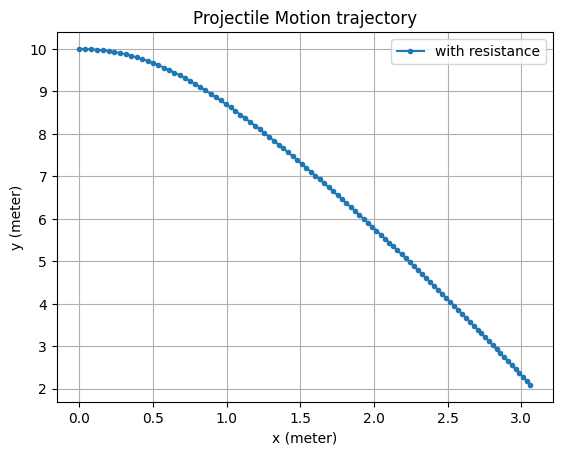

In [24]:
# 绘制轨迹
plt.plot(x_with_resistance, y_with_resistance, label = 'with resistance', marker='o', markersize = 3)
#plt.plot(state_list[:, 0], state_list[:, 1], label = 'Kalman Filter tracking', marker='o', markersize = 3)
plt.xlabel('x (meter)')
plt.ylabel('y (meter)')
plt.title('Projectile Motion trajectory')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
n_train = 20
t_train = ts[:n_train]
x_train = x_with_resistance[:n_train]
y_train = y_with_resistance[:n_train]


In [26]:
# data preparation
n_f = 10000
f_batch_size = 32

reg_in = torch.from_numpy(t_train).type(torch.float32)
reg_in = reg_in[:,None]

reg_xlabel = torch.from_numpy(x_train).type(torch.float32)
reg_xlabel = reg_xlabel[:,None]

f_x = np.random.uniform(0, 5, n_f)
f_xt = np.random.uniform(0, 2, n_f)

f_data_x = np.vstack([f_x, f_xt]).T

f_x = Variable(torch.from_numpy(f_data_x[:, 0:1]).type(torch.FloatTensor), requires_grad=True)
f_xt = Variable(torch.from_numpy(f_data_x[:, 1:2]).type(torch.FloatTensor), requires_grad=True)

f_dataset_x = torch.utils.data.TensorDataset(f_x, f_xt)

f_data_loader_x = torch.utils.data.DataLoader(f_dataset_x, batch_size = f_batch_size, shuffle=True)


In [27]:
# Define a MLP and function f
class MLP(nn.Module):
    def __init__(self, in_dim = 1,  hidden_dim = 128, out_dim = 1):

        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
                                nn.Linear(in_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, out_dim),
                                        )

    def forward(self, data_in):
        return self.mlp(data_in)

model_x = MLP()

def f_x(t, k, m, n):
    u = model_x(t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    return u_tt + (k/m)*u_t**n


optimizer_x = optim.Adam(model_x.parameters(), lr=1e-3)


In [28]:
# Training the PINN in x direction
n_epoch = 20
for epoch in range(n_epoch):
    for x, t in tqdm(f_data_loader_x):
        optimizer_x.zero_grad()
        pred = model_x(reg_in)
        reg_loss = torch.mean((reg_xlabel - pred) ** 2)
        f_loss = torch.mean(f_x(t, k, m, 3) ** 2)

        loss =  reg_loss +f_loss   # adjust the coefficients between two losses
        loss.backward(retain_graph=True)
        optimizer_x.step()

    print("epoch = {}, loss = {}".format(epoch, loss))
    print("epoch = {}, f_loss = {}".format(epoch, f_loss))
    print("epoch = {}, reg_loss = {}".format(epoch, reg_loss))

100%|██████████| 313/313 [00:01<00:00, 267.70it/s]


epoch = 0, loss = 0.0004557123174890876
epoch = 0, f_loss = 0.0003602226497605443
epoch = 0, reg_loss = 9.548968228045851e-05


100%|██████████| 313/313 [00:01<00:00, 277.56it/s]


epoch = 1, loss = 2.149126521544531e-05
epoch = 1, f_loss = 2.0816352844121866e-05
epoch = 1, reg_loss = 6.749132808181457e-07


100%|██████████| 313/313 [00:01<00:00, 281.39it/s]


epoch = 2, loss = 4.818157685804181e-05
epoch = 2, f_loss = 4.018058461952023e-05
epoch = 2, reg_loss = 8.000992238521576e-06


100%|██████████| 313/313 [00:01<00:00, 277.79it/s]


epoch = 3, loss = 0.00023414510360453278
epoch = 3, f_loss = 0.00010864832438528538
epoch = 3, reg_loss = 0.0001254967792192474


100%|██████████| 313/313 [00:01<00:00, 282.34it/s]


epoch = 4, loss = 6.652907904936001e-05
epoch = 4, f_loss = 2.0330135157564655e-05
epoch = 4, reg_loss = 4.619894389179535e-05


100%|██████████| 313/313 [00:01<00:00, 270.79it/s]


epoch = 5, loss = 7.241359526233282e-06
epoch = 5, f_loss = 4.657270892494125e-06
epoch = 5, reg_loss = 2.584088861112832e-06


100%|██████████| 313/313 [00:01<00:00, 284.39it/s]


epoch = 6, loss = 2.4302673409692943e-05
epoch = 6, f_loss = 1.9268440155428834e-05
epoch = 6, reg_loss = 5.034234163758811e-06


100%|██████████| 313/313 [00:01<00:00, 280.74it/s]


epoch = 7, loss = 0.0003570251283235848
epoch = 7, f_loss = 4.61337149317842e-05
epoch = 7, reg_loss = 0.000310891424305737


100%|██████████| 313/313 [00:01<00:00, 280.85it/s]


epoch = 8, loss = 1.6919213521759957e-05
epoch = 8, f_loss = 4.081206498085521e-06
epoch = 8, reg_loss = 1.2838007023674436e-05


100%|██████████| 313/313 [00:01<00:00, 283.43it/s]


epoch = 9, loss = 5.5621127103222534e-05
epoch = 9, f_loss = 9.178263098874595e-06
epoch = 9, reg_loss = 4.644286309485324e-05


100%|██████████| 313/313 [00:01<00:00, 274.32it/s]


epoch = 10, loss = 0.0011119113769382238
epoch = 10, f_loss = 0.0005107531906105578
epoch = 10, reg_loss = 0.0006011581281200051


100%|██████████| 313/313 [00:01<00:00, 253.94it/s]


epoch = 11, loss = 6.133199349278584e-05
epoch = 11, f_loss = 5.801427687401883e-05
epoch = 11, reg_loss = 3.317713435535552e-06


100%|██████████| 313/313 [00:01<00:00, 250.81it/s]


epoch = 12, loss = 0.00015806936426088214
epoch = 12, f_loss = 4.042461659992114e-05
epoch = 12, reg_loss = 0.000117644747660961


100%|██████████| 313/313 [00:01<00:00, 241.96it/s]


epoch = 13, loss = 2.321740976185538e-05
epoch = 13, f_loss = 6.290204964898294e-06
epoch = 13, reg_loss = 1.6927204342209734e-05


100%|██████████| 313/313 [00:01<00:00, 281.20it/s]


epoch = 14, loss = 2.482825038896408e-05
epoch = 14, f_loss = 1.724702087813057e-05
epoch = 14, reg_loss = 7.581229056086158e-06


100%|██████████| 313/313 [00:01<00:00, 273.86it/s]


epoch = 15, loss = 1.3545353795052506e-05
epoch = 15, f_loss = 1.1142218681925442e-05
epoch = 15, reg_loss = 2.403134658379713e-06


100%|██████████| 313/313 [00:01<00:00, 273.01it/s]


epoch = 16, loss = 4.718544369097799e-05
epoch = 16, f_loss = 1.2928974683745764e-05
epoch = 16, reg_loss = 3.425646718824282e-05


100%|██████████| 313/313 [00:01<00:00, 281.08it/s]


epoch = 17, loss = 2.5027569790836424e-05
epoch = 17, f_loss = 2.3884416805231012e-05
epoch = 17, reg_loss = 1.143152303484385e-06


100%|██████████| 313/313 [00:01<00:00, 282.31it/s]


epoch = 18, loss = 1.943454890351859e-06
epoch = 18, f_loss = 1.396396896780061e-06
epoch = 18, reg_loss = 5.470580504152167e-07


100%|██████████| 313/313 [00:01<00:00, 280.72it/s]

epoch = 19, loss = 7.286894833669066e-05
epoch = 19, f_loss = 1.3741439033765346e-05
epoch = 19, reg_loss = 5.912750930292532e-05


In [29]:
# Train a pure MLP in x direction
model_mlp_x = MLP()
optimizer_mlp_x = optim.Adam(model_mlp_x.parameters(), lr=1e-3)
for epoch in range(1000):

        optimizer_mlp_x.zero_grad()
        pred = model_mlp_x(reg_in)
        mlp_loss = torch.mean((reg_xlabel - pred) ** 2)
        mlp_loss.backward()
        optimizer_mlp_x.step()
        print("epoch = {}, loss = {}".format(epoch, mlp_loss))

epoch = 0, loss = 0.14941969513893127
epoch = 1, loss = 0.0523228645324707
epoch = 2, loss = 0.097579225897789
epoch = 3, loss = 0.08023634552955627
epoch = 4, loss = 0.046227168291807175
epoch = 5, loss = 0.037192486226558685
epoch = 6, loss = 0.047050219029188156
epoch = 7, loss = 0.05195299908518791
epoch = 8, loss = 0.043554358184337616
epoch = 9, loss = 0.029761139303445816
epoch = 10, loss = 0.021104583516716957
epoch = 11, loss = 0.02167671173810959
epoch = 12, loss = 0.026118647307157516
epoch = 13, loss = 0.02577834390103817
epoch = 14, loss = 0.018900927156209946
epoch = 15, loss = 0.011005209758877754
epoch = 16, loss = 0.007840121164917946
epoch = 17, loss = 0.009716132655739784
epoch = 18, loss = 0.011647100560367107
epoch = 19, loss = 0.00940336100757122
epoch = 20, loss = 0.004304667003452778
epoch = 21, loss = 0.0011443268740549684
epoch = 22, loss = 0.0023844751995056868
epoch = 23, loss = 0.004865468014031649
epoch = 24, loss = 0.004217515233904123
epoch = 25, loss = 

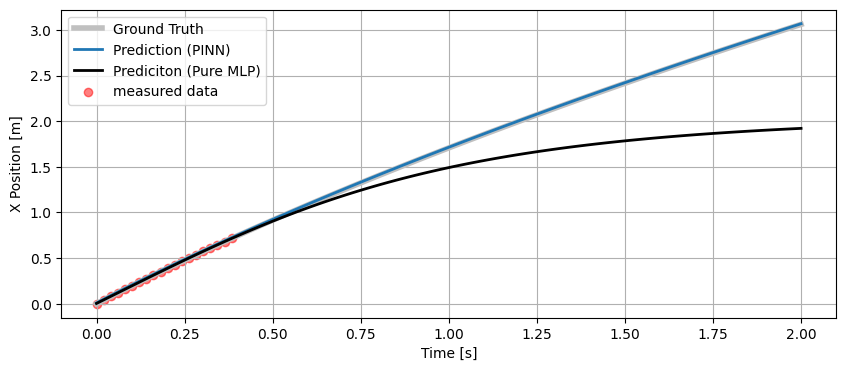

In [31]:
# Time series

ts_torch = torch.from_numpy(ts).type(torch.float32)
ts_torch = ts_torch[:,None]

plt.figure(figsize=(10, 4))
plt.plot(ts, x_with_resistance,color = "silver", lw = 4)
plt.plot(ts, model_x( ts_torch ).detach().numpy(),lw = 2)
plt.plot(ts, model_mlp_x( ts_torch ).detach().numpy(), color = "black", lw = 2)
plt.scatter(t_train, x_train,alpha=0.5, c = "red")
plt.xlabel('Time [s]')
plt.ylabel('X Position [m]')
plt.legend(['Ground Truth', 'Prediction (PINN)', "Prediciton (Pure MLP)","measured data"])
plt.grid(True)